In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
# import oceanDAS as odas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.signal import welch
from obspy import UTCDateTime
# from pyproj import Proj
from datetime import datetime

### Load and plot data

This data was collected on a Sintela Onyx in June-July 2023 on the TERRA-SW cable owned and operated by GCI out of Homer, AK. The segment of channels shown here is about 500 m away from a CDIP wave buoy at the closest point, in water depth around 40 m. The cable direction is roughly E-W (080-092 varying with distance), and the wave direction is almost aways 30-60 degrees oblique to the cable. The tidal currents (as fast as +/- 1 m/s at 12 hr period) strongly modulate the wave spectrum. There is some leakage of swell into the Lower Cook Inlet at long periods, but the wave climate is generally insulated from the Pacific and determined by local wind conditions. Over the month of June, conditions are quite calm, with a mean wave period of 2-7 s and significant wave height of 0.2-1.2 m. 

In [9]:
fdir = '.'#'/data/data1/GCI_OSGW_colab' # your path...
fdir = '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/HomerAK_Williams/'

fname = 'GCI_TERRA_2p5Hz_data.h5'

with h5py.File(os.path.join(fdir,fname),'r') as fp:
    data_rad = fp['RawData'][:]
    time = fp['RawDataTime'][:]
    lon = fp['Longitude'][:]
    lat = fp['Latitude'][:]
    dep = fp['WaterDepth'][:]
    dx = fp['RawData'].attrs['ChannelPitch']
    fs = fp['RawData'].attrs['SamplingRate']
    gl = 17.5476194762 # gauge length, forgot to put it in the file

# get rid of nans - not ideal, but there are only 20 missing samples total
nx = data_rad.shape[1]
data_rad = data_rad[~np.isnan(data_rad)]
data_rad = data_rad.reshape((len(data_rad)//nx,nx))
time = time[~np.isnan(time)]

ns = data_rad.shape[0]
nx = data_rad.shape[1]

[]


In [3]:
# From radians to strain
n = 1.4682
l = 1550.12e-9
data_e = data_rad * l/(2*np.pi*0.78*n*gl)
del data_rad

In [4]:
# Format dates
#ddateu = np.array([UTCDateTime(t*1e-6) for t in time]) # this is too memory intensive, tried on my laptop
#ddatem = np.array([d.matplotlib_date for d in ddateu])
ddatem = time * 1e-6 / (60*60*24)

In [6]:
with h5py.File(os.path.join(fdir,'NDBC-46108_spectra.h5'),'r') as fp:
    sdate = fp['DATE'][:] # POSIX time stamp (ns)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz
with h5py.File(os.path.join(fdir,'NDBC-46108_statistics.h5'),'r') as fp:
    ndate = fp['DATE'][:] # POSIX time stamp (ns)
    WVHT = fp['WVHT'][:] # significant wave height (m)
    SwH = fp['SwH'][:] # swell height (m)
    SwP = fp['SwP'][:] # swell period (s)
    WWH = fp['WWH'][:] # wind wave height (m)
    WWP = fp['WWP'][:] # wind wave period (s)
    SwD = fp['SwD'][:] # swell direction (N, NNW, NW, WNW, ...)
    WWD = fp['WWD'][:] # wind wave direction 
    APD = fp['APD'][:] # average wave period (s)
    MWD = fp['MWD'][:] # mean wave direction (deg)
with h5py.File(os.path.join(fdir,'NDBC-46108_adcp.h5'),'r') as fp:
    adate = fp['DATE'][:] # POSIX time stamp (ns)
    cdir = fp['DIR'][:] # flow direction at 1-m depth (deg)
    cspd = fp['SPD'][:] # flow speed at 1-m depth (cm/s)

In [9]:
# Convert date formats
sdateu = np.array([UTCDateTime(d*1e-9) for d in sdate])
ndateu = np.array([UTCDateTime(d*1e-9) for d in ndate])
adateu = np.array([UTCDateTime(d*1e-9) for d in adate])

sdatem = np.array([d.matplotlib_date for d in sdateu])
ndatem = np.array([d.matplotlib_date for d in ndateu])
adatem = np.array([d.matplotlib_date for d in adateu])

In [12]:
nt = len(sdate)     # number of buoy spectra
nns = int(200*fs)   # number of samples for each FFT (to match buoy resolution)
nnw = int(nns//2+1) # number of frequency samples in RFFT
nov = int(nns//2)   # overlap for Welch's method
nsg = int(30*60*fs) # number of samples in each window
nwn = int(nsg//nns) # number of FFTs in each window

# Calculate spectra
spec_e = np.zeros((nt,nnw,nx))
for it in range(nt):
    ii = np.argmin(abs(sdatem[it]-ddatem))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    freq_e,spec_e[it,:,:] = welch(data_e[i1:i2,:],fs=fs,nperseg=nns,\
                          noverlap=nov,detrend=False,scaling='density',axis=0)

# clear data variable from memory
del data_e

In [13]:
# Truncate buoy frequency precision at 1 mHz
sfreq2 = (sfreq*1e3).astype(int)*1e-3

# The buoy spectrum is irregularly sampled
# Cut out the samples to align, but perhaps there should be some re-normalization?
idx = np.zeros(len(sfreq2),dtype=int)
for i,fi in enumerate(sfreq2):
    idx[i] = np.argmin(abs(freq_e-fi))
freq2_e = freq_e[idx]  # Hz
spec2_e = spec_e[:,idx,:] # strain^2/Hz

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


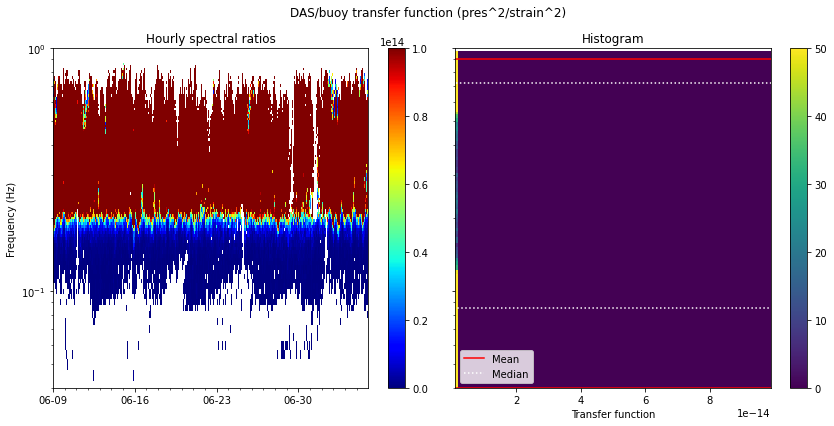

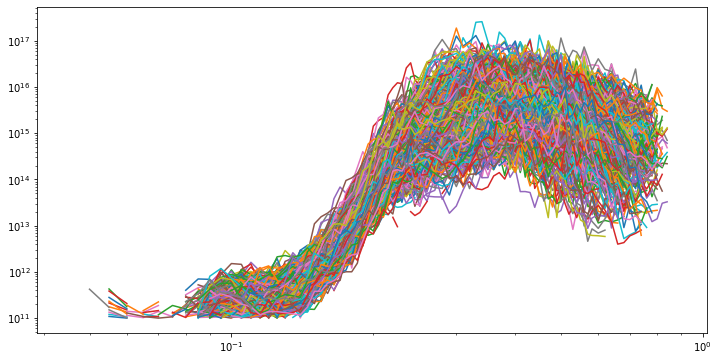

In [17]:
ichan = 31 # compare with the middle channel

# Histogram comparison of spectral ratios across the full month
a = np.linspace(0,1e-13,50)              # psd bins
am = 0.5*(a[1:]+a[:-1])                  # psd bin centers
h = np.zeros((len(sfreq),len(a)-1))      # histogram

# #calculate depth attenuation function for this channel location
depth = dep[0]*(-1)
T = 1 / sfreq
_,k = odas.dispersion(depth,T)


attenuation = np.exp(k*depth)
attenuation = attenuation**2; # square for energy 
# #calculate equivalent attenuated SWIFT spectra
sspec = sspec/attenuation
ss = (sspec/spec2_e[:,:,ichan])  # ratio of pres/strain

m1 = np.zeros(len(sfreq)); m2 = np.zeros(len(sfreq)); std = np.zeros(len(sfreq))
for i in range(len(sfreq)):
    idx = np.logical_or(np.isinf(ss[:,i]),np.isnan(ss[:,i]))
    h[i,:],_ = np.histogram(ss[~idx,i],bins=a)
    m1[i] = np.mean(ss[~idx,i])   # mean
    m2[i] = np.median(ss[~idx,i]) # median
    std[i] = np.std(ss[~idx,i])   # standard deviation
ss[ss<10e10]=np.NaN
# # Plot
# fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True) #,width_ratios=[3,1]
# im0 = ax[0].pcolormesh(sdatem,sfreq,ss.T,cmap='jet',vmin=0,vmax=1e14)# 
# ax[0].set_yscale('log')
# ax[0].set_ylim([4e-2,1e0])
# ax[0].set_ylabel('Frequency (Hz)')
# ax[0].set_title('Hourly spectral ratios')
# ax[0].xaxis.set_major_formatter(date_form)
# ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# im1 = ax[1].pcolormesh(am,sfreq,h,vmin=0,vmax=50)
# ax[1].plot(m1,sfreq,'r',label='Mean')
# ax[1].plot(m2,sfreq,'w:',label='Median')
# ax[1].legend(loc='lower left')
# ax[1].set_xlim([min(am),max(am)])
# ax[1].set_xlabel('Transfer function')
# ax[1].set_title('Histogram')
# fig.suptitle('DAS/buoy transfer function (pres^2/strain^2)')
# fig.colorbar(im0,ax=ax[0])
# fig.colorbar(im1,ax=ax[1])
# fig.tight_layout()


fig,ax = plt.subplots(1,1,figsize=(12,6))
for jj in range(len(sdatem)):
    ax.plot(sfreq,ss[jj,:])
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([4e-2,0.35])

ss_med = np.nanmedian(ss,axis=0)

np.savez(fdir+'empCalex_Ch31',x=sfreq,y=ss_med)